In [1]:
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from os import listdir
import mnist_reader
import random
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import xgboost as xgb

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import accuracy_score, classification_report


import warnings
warnings.filterwarnings('ignore')

## <u><b> Part 1: </b></u>
### Loading our data


In [2]:
#our random seed for reproducible model
#randomSeed = 834
randomSeed = 36
data, target = mnist_reader.load_mnist(r'data/fashion', kind='train')
final_X_test, final_y_test = mnist_reader.load_mnist(r'data/fashion', kind='t10k')


data,data.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 (60000, 784))

In [3]:
target,target.shape

(array([9, 0, 0, ..., 3, 0, 5], dtype=uint8), (60000,))

In [4]:
np.isnan(data).any(),np.isnan(target).any()

(False, False)

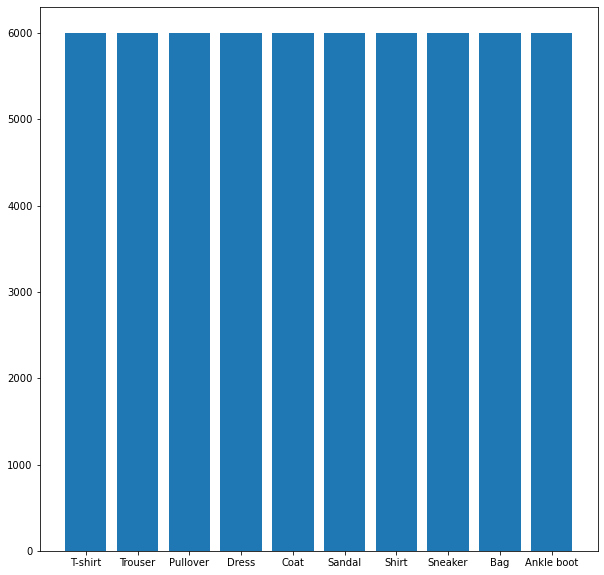

In [5]:
plt.figure(figsize=(10,10))
plt.bar(np.unique(target),np.bincount(target))
plt.xticks(np.unique(target),["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"])

plt.show()

In [6]:
#assumes pics are 28x28
def plotIMGS(data,size):
    fig, axs = plt.subplots(size, size)
    fig.set_size_inches(2.8*size,2.8*size)
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            label = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
            idx = random.randint(0,len(data)-1)
            axs[i,j].imshow(data[idx].reshape((28,28)),cmap="gray",vmin=0, vmax=255)
            axs[i,j].set_title(label[target[idx]])

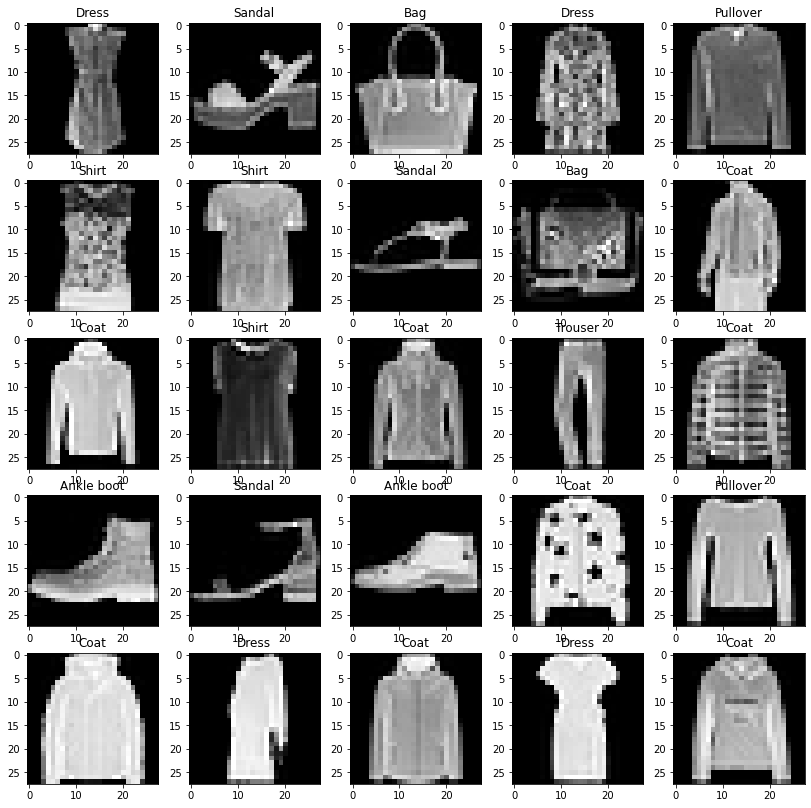

In [7]:
plotIMGS(data,5)

## <u><b> Part 2 </b></u>

### Train/Test split

We will find a model that that can predict our train data well before trying it on the entire final train and final test data 

In [8]:
X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.25,random_state=randomSeed)

## <u><b> Part 3 </b></u>
### constructing our pipeline

In [9]:
pca = PCA(random_state=randomSeed)
pca.fit(X_train)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

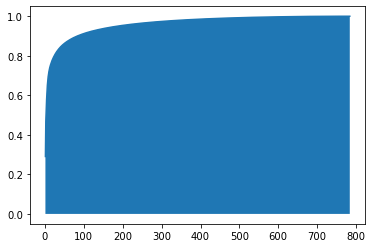

In [10]:
fig, ax = plt.subplots()
ax.plot(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul)
ax.fill_between(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul,0)

In [11]:
dim = len(exp_var_cumul[exp_var_cumul<0.925])
exp_var_cumul[dim], dim

(0.9251785571234371, 121)

In [12]:
pipe = Pipeline([
    ("pca",PCA(n_components=dim,random_state=randomSeed))
],verbose=True)

X_train_new = pipe.fit_transform(X_train)
X_test_new = pipe.transform(X_test)

[Pipeline] ............... (step 1 of 1) Processing pca, total=   2.0s


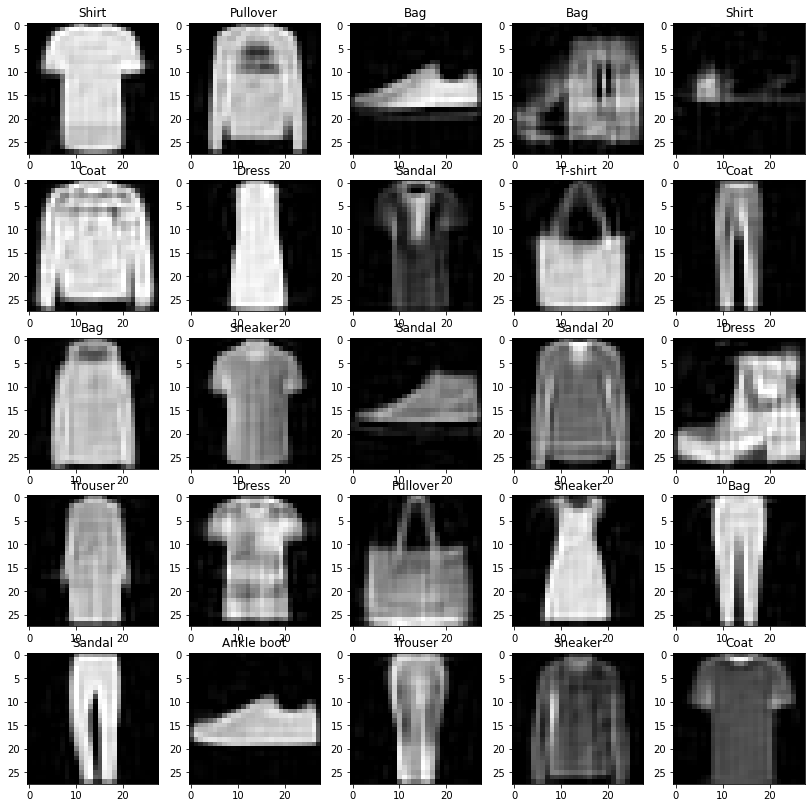

In [13]:
imgs = pipe.inverse_transform(X_train_new)
plotIMGS(imgs,5)

## <u><b> Part 4 </b></u>
### Baseline model

We will make a baseline model and try to beat it

In [14]:
baseline = xgb.XGBClassifier(n_estimators=10,random_state=randomSeed,n_jobs=-1,verbosity=0)
baseline.fit(X_train_new,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=36, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [15]:
baseline_predict = baseline.predict(X_test_new)

In [16]:
print("Accuracy:",accuracy_score(y_test,baseline_predict))
print(classification_report(y_test,baseline_predict))

Accuracy: 0.8393333333333334
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1476
           1       0.99      0.95      0.97      1517
           2       0.74      0.76      0.75      1496
           3       0.83      0.88      0.86      1505
           4       0.73      0.80      0.76      1493
           5       0.90      0.89      0.90      1491
           6       0.67      0.51      0.58      1490
           7       0.91      0.90      0.90      1519
           8       0.94      0.91      0.92      1526
           9       0.91      0.95      0.93      1487

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



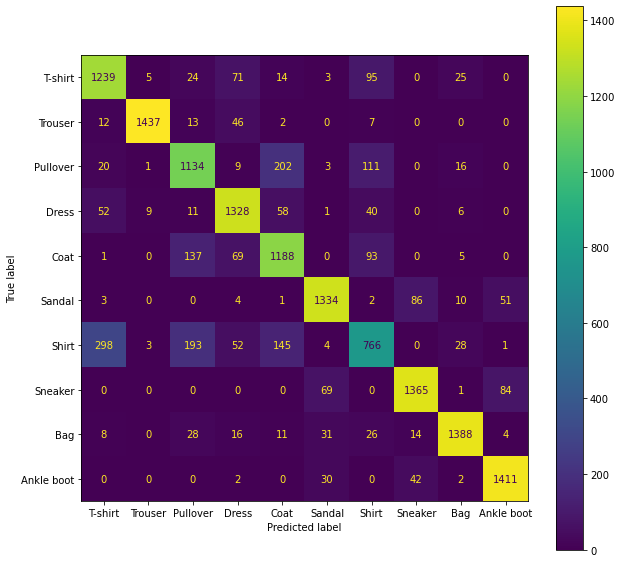

In [17]:
fig, (ax1) = plt.subplots(1, 1)

fig.set_size_inches(10,10)
plot_confusion_matrix(baseline,X_test_new,y_test,display_labels=["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"],values_format="d",ax=ax1)

## <u><b> Part 5 </b></u>
### Parmater tuning

We will use DMatrix provided by the xgboost module and use xgb.cv to find optimal paramaters,
this will be much faster than doing a gridsearch since we can define early stopping round instead of specifying a certain 
amount of estimators


In [18]:
dtrain = xgb.DMatrix(X_train_new, label=y_train)
dtest = xgb.DMatrix(X_test_new, label=y_test)


In [19]:
def param_search(param_grid,train,test,train_labels,test_labels,randomSeed=randomSeed,nfolds=5,eval_method="mlogloss",num_class=10,num_boost_round=10000,early_stopping_rounds=50,verbose=True):
    done = 0
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    amount = len(param_grid)
    params = {
        'random_state':randomSeed,
        'eval_metric':eval_method,
        'num_class':num_class,
    }
    start = time.time()
    timer = time.time()
    best_eval = float("inf")
    best_eval_train = 0
    best_params = {}
    best_iter = 0
    best_out = ''
    with tqdm(total=len(param_grid)) as pbar:
        for p in param_grid:
            out = ''
            for key in p:
                params[key] = p[key]
                out += key + '=' + str(p[key])+', '
            out = out[:-2]

            results = xgb.cv(params,train,num_boost_round=num_boost_round,nfold=nfolds,metrics={eval_method},early_stopping_rounds=early_stopping_rounds,seed=randomSeed)

            ax1.plot(results.index,results['test-'+eval_method+'-mean'],label=out[:25])
            ax2.plot(results.index,results['train-'+eval_method+'-mean'],label=out[:25])
            ax1.set_title("validation")
            ax2.set_title("train")
            ax1.legend()
            ax2.legend()

            done +=1 
            #get mean score of cv of the training and testing, and get the best iteration
            mean_eval_test = results['test-'+eval_method+'-mean'].min()
            mean_eval_train = results['test-'+eval_method+'-mean'].min()
            iteration = results['test-'+eval_method+'-mean'].argmin()


            #update best parameters
            if mean_eval_test < best_eval:
                best_eval = mean_eval_test
                best_eval_train = mean_eval_train

                best_iter = iteration
                best_out = ''
                for key in p:
                    best_out += key + '=' + str(p[key])+', '
                    best_params[key] = p[key]
                best_out = best_out[:-2]

            #show results of cv
            if verbose:
                print("Parameters: "+out)
                print("Mean train "+eval_method+": "+str(mean_eval_train) + " Mean test "+eval_method+": "+str(mean_eval_test) + " Iteration: "+str(iteration))
                print(str(done)+"/"+str(amount))
                print("")
                if (time.time()-timer) > 300:
                    print(str((time.time()-start)/60) +"m elapsed. Finished "+str(100*done/amount)+"%" )
                    timer = time.time()
                print("")
                pbar.update(1)
    stop = time.time()
    if verbose:
        print("----------------------------------------")
    print(f"Tuning time: {(time.time()-start)/60}m")
    print("Best parameters: "+best_out+":")
    print("Best mean train "+eval_method+": "+str(best_eval_train) + " Best mean test "+eval_method+": "+str(best_eval) + " Best iteration: "+str(best_iter))
    
    #show accuracy score
    bst = xgb.train(dict({'random_state':randomSeed,'eval_metric':eval_method,'num_class':num_class},**best_params), train, best_iter+1)
    test_preds = bst.predict(test)
    train_preds = bst.predict(train)
    print("Test accuracy:",accuracy_score(test_labels,test_preds),"Train accuracy:",accuracy_score(train_labels,train_preds))
    return best_params,best_iter

In [20]:
params = {
    'tree_method':'hist',
    'n_jobs':-1,
    'objective':"multi:softmax"
}

In [21]:
grid = [
    dict({'learning_rate':lr},**params) 
    for lr in [0.05,0.1,0.3,0.5]
]

  0%|          | 0/4 [00:00<?, ?it/s]

Parameters: learning_rate=0.05, tree_method=hist, n_jobs=-1, objective=multi:softmax
Mean train mlogloss: 0.33398900000000004 Mean test mlogloss: 0.33398900000000004 Iteration: 537
1/4

10.287859737873077m elapsed. Finished 25.0%

Parameters: learning_rate=0.1, tree_method=hist, n_jobs=-1, objective=multi:softmax
Mean train mlogloss: 0.3351636 Mean test mlogloss: 0.3351636 Iteration: 251
2/4

19.47760073343913m elapsed. Finished 50.0%

Parameters: learning_rate=0.3, tree_method=hist, n_jobs=-1, objective=multi:softmax
Mean train mlogloss: 0.34912319999999997 Mean test mlogloss: 0.34912319999999997 Iteration: 81
3/4

25.647375059127807m elapsed. Finished 75.0%

Parameters: learning_rate=0.5, tree_method=hist, n_jobs=-1, objective=multi:softmax
Mean train mlogloss: 0.3685966 Mean test mlogloss: 0.3685966 Iteration: 48
4/4


----------------------------------------
Tuning time: 30.56735058625539m
Best parameters: learning_rate=0.05, tree_method=hist, n_jobs=-1, objective=multi:softmax:
Be

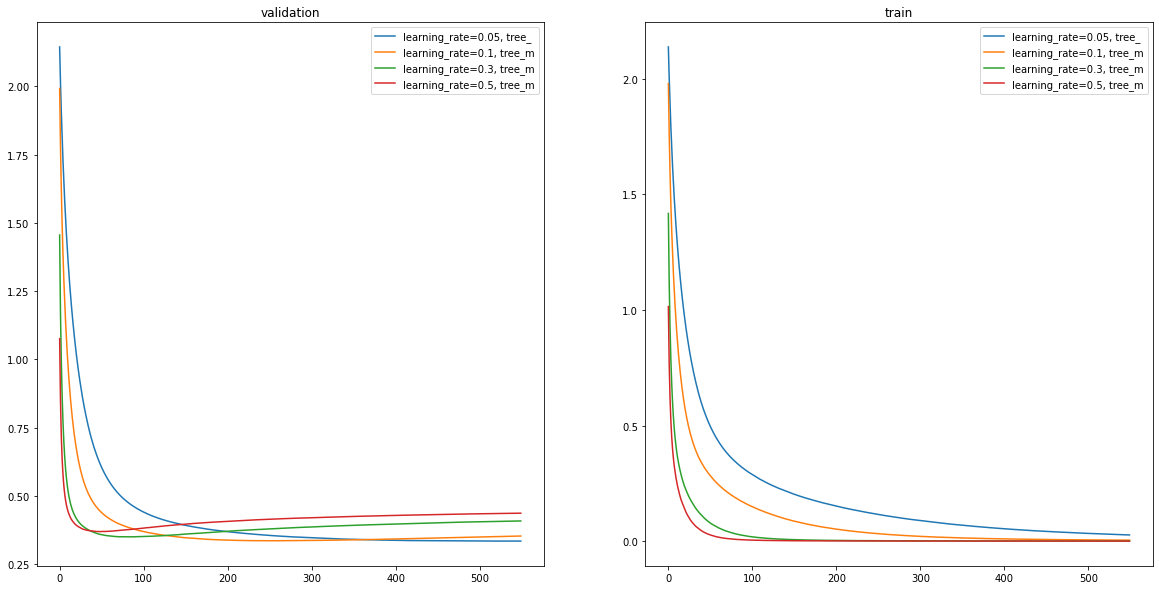

In [22]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test,num_boost_round=550,early_stopping_rounds=None)


In [23]:
grid = [
    dict({'max_depth':i,'min_child_weight':j},**params) 
    for i in [3,6,10]
    for j in [1,5,10]
]


In [ ]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

  0%|          | 0/9 [00:00<?, ?it/s]

Parameters: max_depth=3, min_child_weight=1, learning_rate=0.05, tree_method=hist, n_jobs=-1, objective=multi:softmax
Mean train mlogloss: 0.33384139999999995 Mean test mlogloss: 0.33384139999999995 Iteration: 2042
1/9

16.832949209213258m elapsed. Finished 11.11111111111111%

Parameters: max_depth=3, min_child_weight=5, learning_rate=0.05, tree_method=hist, n_jobs=-1, objective=multi:softmax
Mean train mlogloss: 0.333316 Mean test mlogloss: 0.333316 Iteration: 1919
2/9

31.63373057047526m elapsed. Finished 22.22222222222222%

Parameters: max_depth=3, min_child_weight=10, learning_rate=0.05, tree_method=hist, n_jobs=-1, objective=multi:softmax
Mean train mlogloss: 0.3322078 Mean test mlogloss: 0.3322078 Iteration: 2117
3/9

47.108024048805234m elapsed. Finished 33.333333333333336%

Parameters: max_depth=6, min_child_weight=1, learning_rate=0.05, tree_method=hist, n_jobs=-1, objective=multi:softmax
Mean train mlogloss: 0.33398900000000004 Mean test mlogloss: 0.33398900000000004 Iteratio

In [ ]:
grid = [
    dict({'gamma':g},**params) 
    for g in [0,1,5]
]

In [ ]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [ ]:
grid = [
    dict({'subsample':i,'colsample_bytree':j},**params) 
    for i in [0.5,1]
    for j in [0.5,1]
]

In [ ]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test,num_boost_round=900,early_stopping_rounds=None)


In [ ]:
grid = [
    dict({'reg_lambda':i},**params) 
    for i in [1,10,20,25]
]

In [ ]:
params,estimators = param_search(grid,dtrain,dtest,y_train,y_test)

## <u><b> Part 6: </b></u>
### Final model

We will use our paramaters we got from the last part as the paramaters for our final model

In [ ]:
model = xgb.XGBClassifier(n_estimators = estimators, random_state=randomSeed,**params,eval_metric="mlogloss",num_class=10)

In [ ]:
model.fit(X_train_new,y_train)

In [ ]:
pred_test = model.predict(X_test_new)
pred_train = model.predict(X_train_new)

In [ ]:
print("Train accuracy:",accuracy_score(y_train,pred_train))
print(classification_report(y_train,pred_train))

In [ ]:
print("Test accuracy:",accuracy_score(y_test,pred_test))
print(classification_report(y_test,pred_test))

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
 
fig.set_size_inches(20,10)
plot_confusion_matrix(model,X_test_new,y_test,display_labels=["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"],values_format="d",ax=ax1)
plot_confusion_matrix(model,X_train_new,y_train,display_labels=["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"],values_format="d",ax=ax2)
ax1.set_title("Test")
ax2.set_title("Train")

## <u><b> Part 7: </b></u>
### Testing model on the final data

We will now fit our model using the entire fashion MNIST training data, and check our accuracy on the final test data

In [ ]:
train = pipe.fit_transform(data)
test = pipe.transform(final_X_test)

In [ ]:
model.fit(train,target)

In [ ]:
pred_test = model.predict(test)
pred_train = model.predict(train)

In [ ]:
print("Test accuracy:",accuracy_score(final_y_test,pred_test))
print(classification_report(final_y_test,pred_test))

In [ ]:
print("Train accuracy:",accuracy_score(target,pred_train))
print(classification_report(target,pred_train))

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
 
fig.set_size_inches(20,10)
plot_confusion_matrix(model,test,final_y_test,display_labels=["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"],values_format="d",ax=ax1)
plot_confusion_matrix(model,train,target,display_labels=["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"],values_format="d",ax=ax2)
ax1.set_title("Test")
ax2.set_title("Train")